## SEO Dashboard with Google Analytics Data

This report explores how we can pull in website data from Google Analytics and find insights on SEO. If you want to run this notebook, the install instructions are kept [in the Readme.md](/Readme.md).

### Introduction

Google Analytics is a website traffic analysis application that provides real-time statistics and analysis of user interaction with the website. Google analytics enables website owners to analyze their visitors, with the objective of interpreting and optimizing website's performance.

In this report we will learn how to pull in the data using the Google Analytics Reporting API and graph some interesting SEO metrics to show meaningful insights.

In [1]:
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build
import httplib2
import pandas as pd
import json
import numpy as np

import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf
from cufflinks import tools
from pandas.io.json import json_normalize

### Create Globsal Variables For Data Access

If you haven't already, check out the Readme.md file on this repository for instructions on how to creeate a project in the Google API Console, to enable the API, and create the key file, which you should save to this directory.

**Remeber to add the _client_secrets.json_ file to your .gitignore!**

Replace the VIEW_ID value with your own. You can use the [Account Explorer](https://ga-dev-tools.appspot.com/account-explorer/) to find your View ID.

In [2]:
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = 'client_secrets.json'
VIEW_ID = '139131559'

### Define Functions To Pull In Our Data

Below we are defining our functions that will 1.) initialize an Analytics Reporting API V4 service object with our credentials created above, and 2.) will query this Analytics Reporting API and returns its response.

## Analyzing Key SEO Metrics

Imagine we are a startup that has recently doubled-down on their SEO efforts through its content marketing strategy, publishing and distributing various types of content across multiple channels. Let's get a broad overview of how this strategy is working for us.

***
The [Google Analytics Metric and Dimension Explorer](https://ga-dev-tools.appspot.com/dimensions-metrics-explorer/) is a great resource to use when searching for the dimensions and metrics you want to visualize, which will largely depend on your business and your digital marketing strategy.
***

### Has Our Organic Traffic Improved Over Time?

- Let's pull in the data we need to answer this question. The main dimension is *date*, and we want to look at the *Medium*, split between Organic Traffic (labelled as *(none)*) and Non-Organic Traffic *(all other)*.

In [4]:
organic_query = {
                'viewId': VIEW_ID, 
                'dateRanges': [{'startDate': '2019-01-01', 
                                'endDate': '2019-06-01'}],
                'metrics': [{'expression': 'ga:sessions'}], 
                'dimensions': [{"name":"ga:yearweek"}], 
                'filtersExpression':'ga:medium=~(none)'
            }

nonorganic_query = {
                'viewId': VIEW_ID, 
                'dateRanges': [{'startDate': '2019-01-01', 
                                'endDate': '2019-06-01'}],
                'metrics': [{'expression': 'ga:sessions'}], 
                'dimensions': [{"name":"ga:yearweek"}], 
                'filtersExpression':'ga:medium!=~(none)'
            }

top_landing_pages_query = {
                'viewId': VIEW_ID, 
                'dateRanges': [{'startDate': '2019-01-01', 
                                'endDate': '2019-06-01'}],
                'metrics': [{'expression': 'ga:pageviews'},
                            {'expression': 'ga:avgSessionDuration'},
                           {'expression': 'ga:bounceRate'}], 
                'dimensions': [{"name":"ga:landingPagePath"}],
                'orderBys': [{"fieldName": "ga:pageviews", "sortOrder": "DESCENDING"}], 
            }

credentials = ServiceAccountCredentials.from_json_keyfile_name(KEY_FILE_LOCATION, SCOPES)
analytics = build('analyticsreporting', 'v4', credentials=credentials)

In [7]:
response = analytics.reports().batchGet( body={ 
    'reportRequests': [
        organic_query,
        nonorganic_query,
        top_landing_pages_query
    ] 
} ).execute();

# Prepare the dataframes

In [37]:
df_sessions = pd.DataFrame({
    'Date': [x['dimensions'][0] for x in response['reports'][0]['data']['rows']],
    'Organic Sessions': [x['metrics'][0]['values'][0] for x in response['reports'][0]['data']['rows']],
    'Non-organic Sessions': [x['metrics'][0]['values'][0] for x in response['reports'][1]['data']['rows']],
})

df_sessions['Date'] = df_sessions['Date'].str.slice(0,4) + '-' + df_sessions['Date'].str.slice(4,6)
df_sessions = df_sessions.astype({ 'Organic Sessions': int, 'Non-organic Sessions': int})

df_landing_pages = pd.DataFrame({
    'Landing Page': [x['dimensions'][0] for x in response['reports'][2]['data']['rows']],
    'Page Views': [x['metrics'][0]['values'][0] for x in response['reports'][2]['data']['rows']],
    'Avg Session Duration': [x['metrics'][0]['values'][1] for x in response['reports'][2]['data']['rows']],
    'Bounce Rate': [x['metrics'][0]['values'][2] for x in response['reports'][2]['data']['rows']],
})

df_landing_pages = df_landing_pages.astype({ 'Page Views': int, 'Avg Session Duration': float, 'Bounce Rate': float})

# Save to cache so we dont need to download all the time

In [41]:
with open('cache/sessions.json', 'w') as f:
    f.write(df_sessions.to_json(indent=2))
    
with open('cache/landing_pages.json', 'w') as f:
    f.write(df_landing_pages.to_json(indent=2))

In [42]:
df_sessions = pd.read_json('cache/sessions.json')
df_landing_pages = pd.read_json('cache/landing_pages.json')

In [39]:
df_sessions.head()

,Date,Organic Sessions,Non-organic Sessions
0,2019-01,64,191
1,2019-02,226,445
2,2019-03,437,898
3,2019-04,258,590
4,2019-05,258,2246


In [40]:
df_landing_pages.head()

,Landing Page,Page Views,Avg Session Duration,Bounce Rate
0,/,32130,297.056252,40.714896
1,/KyleOS/nbestimate,16341,17.580603,93.522743
2,/becca/world-happiness,8574,23.884480,91.349528
3,/KyleOS/atmospheric-co2-concentrations-2,7285,5.826867,89.210079
4,/KyleOS/cufflinks-intro,4944,74.009578,80.514816


# Start plotting

<ipython-input-11-d9376e1e91b1>:11: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



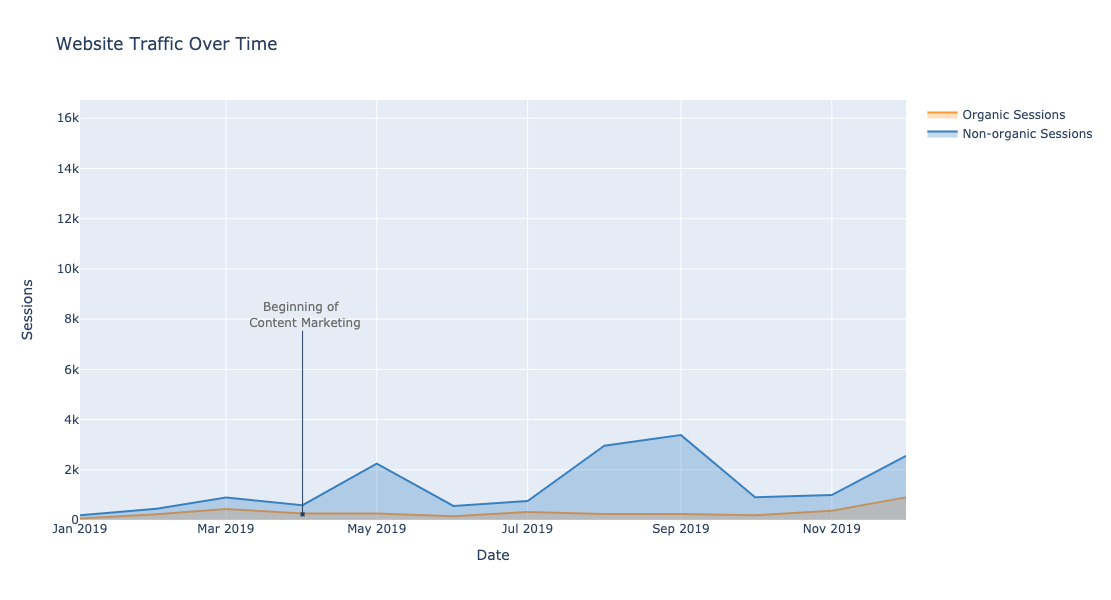

In [11]:
layout = cf.Layout(
    height = 600,
    width = 800,
    yaxis = dict(
    title = 'Sessions'),
    xaxis = dict(
    title = 'Date'),
    title = 'Website Traffic Over Time'
)

fig = df_sessions.groupby(['Date'],as_index=True)['Organic Sessions','Non-organic Sessions'].mean().\
    iplot(kind='scatter',
          fill=True,
          width=2,
          asFigure=True,
          layout = layout)

fig.layout.annotations = [
        dict(
            x='2019-04',
            y='225',
            text='Beginning of <br> Content Marketing',
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-200,
            font=dict(
            size=12,
            color='rgb(107, 107, 107)'
            )
        )
]

fig.show()

### Where Does This Search Result Traffic Land?

- As mentioned above, this startup creates lots of different types of content to drive traffic to the website.
- We want to know not only what pieces of content are getting the most results but also the type of content that is most successful.
- Let's pull in the data we need to answer this question. We will look at the top 10 landing pages by pageviews, along with their bounce rates and average session durations.

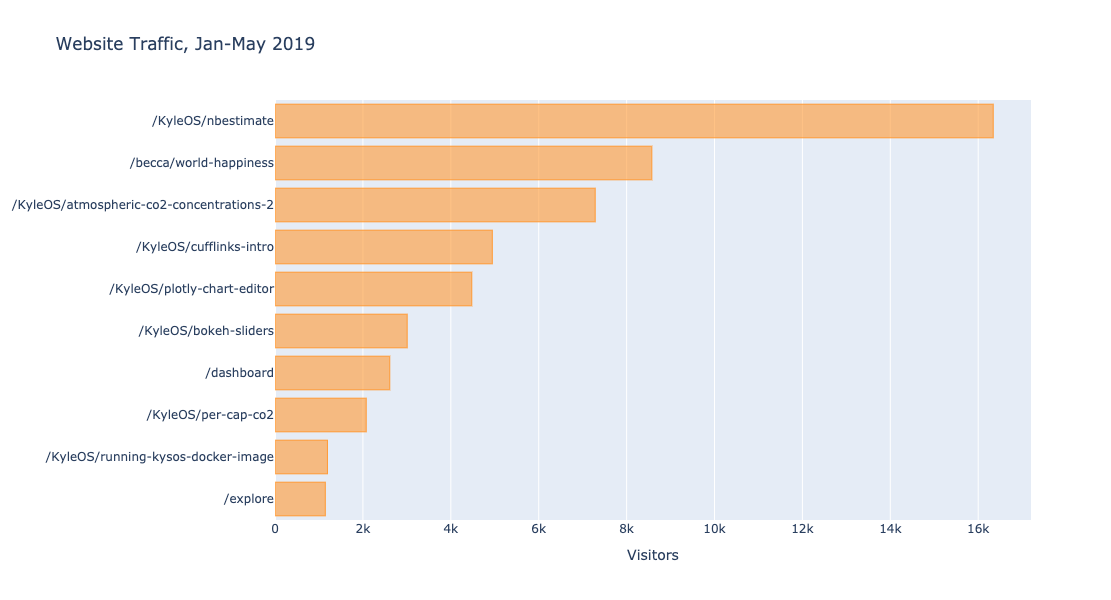

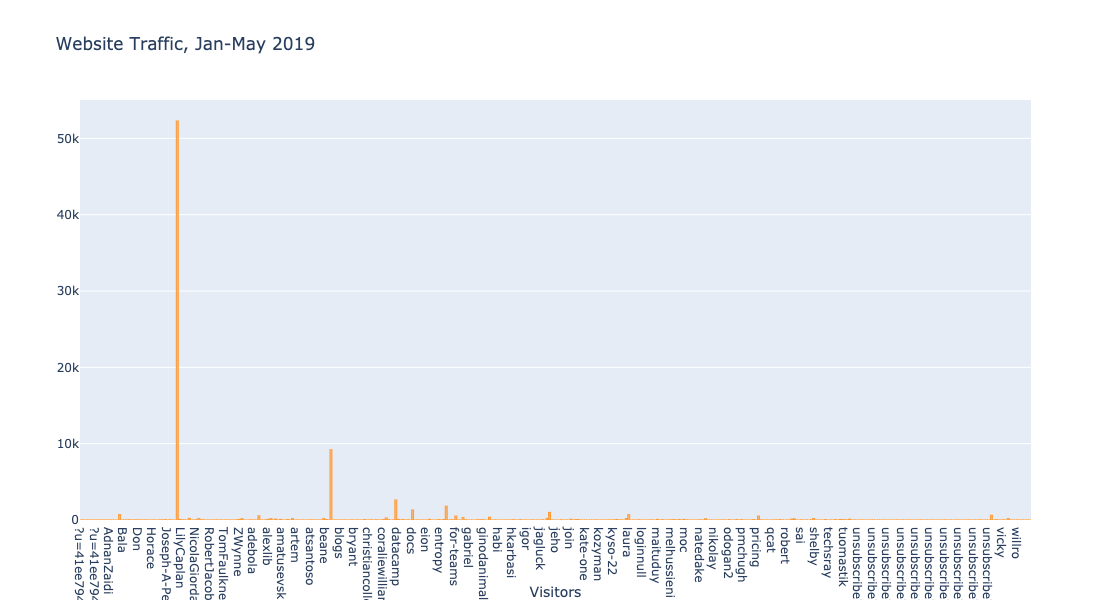

In [16]:
temp_df = df_landing_pages.groupby(['Landing Page'],as_index=True)['Page Views'].mean().sort_values(ascending=False)[1:].head(10)

layout = cf.Layout(
    height = 600,
    width = 800,
    xaxis = dict(title = 'Visitors'),
    title = 'Website Traffic, Jan-May 2019'
)

fig = temp_df.sort_values().\
    iplot(asFigure=True,
          kind = 'barh',
         layout=layout)
    
fig.update_layout(
    margin=dict(l=200),
)

fig.show()

df_landing_pages['Landing Page'] = df_landing_pages['Landing Page'].str.rsplit('/',expand=True)[1]
df_landing_pages = df_landing_pages.iloc[1:]
df_landing_pages = pd.DataFrame(df_landing_pages.groupby(['Landing Page'],as_index=True)['Page Views'].sum())
df_landing_pages.iplot(asFigure=True,layout=layout, kind='bar')

- We can see that the regular articles in their journal drives the most traffic overall.
- However, this might be because their are simply more *Journal* articles being published that *Templates* or *Tutorials*.

### What Is The Quality Of This Content?

- One way to proxy this is to calculate the distribution of session duration and bounce rates across our different types of landing pages.
- We already have the data available so let's go straight into plotting.

In [14]:
layout = cf.Layout(
    height = 600,
    width = 800,
    title = 'Measuring Quality of Content'
)

fig = df_landing_pages.groupby('Landing Page')[['Page Views','Avg Session Duration','Bounce Rate']].mean().iplot(asFigure=True, kind='bar', 
                                                                                              subplots=True, subplot_titles=True, 
                                                                                                    legend=False)

fig.layout.height = 600
fig.layout.width = 800
fig.layout.template = 'plotly'

fig.layout.yaxis2.ticksuffix = 's'
fig.layout.yaxis3.ticksuffix = '%'

fig.show()

KeyError: "Columns not found: 'Bounce Rate', 'Avg Session Duration'"